In [ ]:
print('hi')

1. An MNIST Classifier With Over 97% Accuracy

Exercise: Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [49]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist.data, mnist.target

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

In [51]:
from sklearn.model_selection import GridSearchCV

params = [{"weights": ["uniform", "distance"], "n_neighbors" : [3,4,5,6]}]

grid_search = GridSearchCV(knn_clf, params, cv = 5)

grid_search.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [52]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [53]:
grid_search.best_score_

np.float64(0.9441999999999998)

In [54]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

2. Data Augmentation

Exercise: Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the shift() function from the scipy.ndimage module. For example, shift(image, [2, 1], cval=0) shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation or training set expansion._

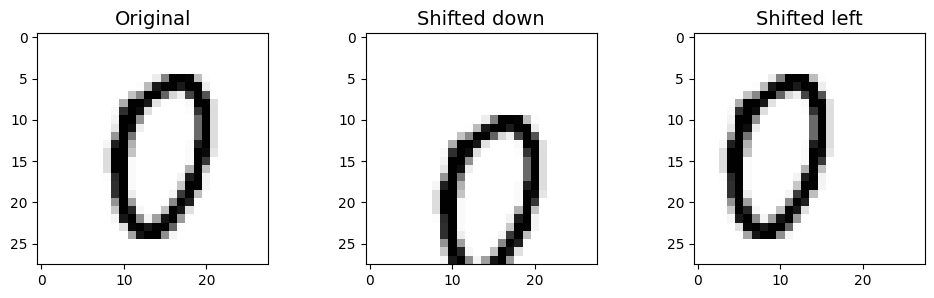

In [55]:

from scipy.ndimage import shift
import matplotlib.pyplot as plt

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

image = X_train[1000]  # some random digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [56]:
import numpy as np

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [58]:
print(X_train_augmented.shape)
print(X_train.shape)

(300000, 784)
(60000, 784)


In [59]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [60]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [61]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

In [63]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%


3. Tackle the Titanic dataset

Exercise: Tackle the Titanic dataset. A great place to start is on Kaggle. Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv and test.csv which you can load using pandas.read_csv(). The goal is to train a classifier that can predict the Survived column based on the other columns

In [64]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

train_data, test_data = load_titanic_data()

In [68]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [69]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [70]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [74]:
train_data[train_data["Sex"] == "female"]["Age"].median()

np.float64(27.0)

In [75]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [76]:
train_data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [78]:
train_data['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [79]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [80]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

#Numerical Preprocessing pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

#Categorical Preprocessing pipeline
cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(sparse_output=False))
])

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

X_train = preprocess_pipeline.fit_transform(train_data)
X_train


array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [83]:
y_train = train_data['Survived']
y_train

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [84]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [85]:
X_test = preprocess_pipeline.fit_transform(test_data)
y_pred = rf_clf.predict(X_test)

In [91]:
from sklearn.model_selection import cross_val_score

rf_scores = cross_val_score(rf_clf, X_train, y_train, cv = 10)
rf_scores.mean()

np.float64(0.8137578027465668)

In [92]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv = 10)
svm_scores.mean()

np.float64(0.8249313358302123)

C:\Users\Acer\AppData\Local\Temp\ipykernel_9796\1899363143.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([svm_scores, rf_scores], labels=("SVM", "Random Forest"))


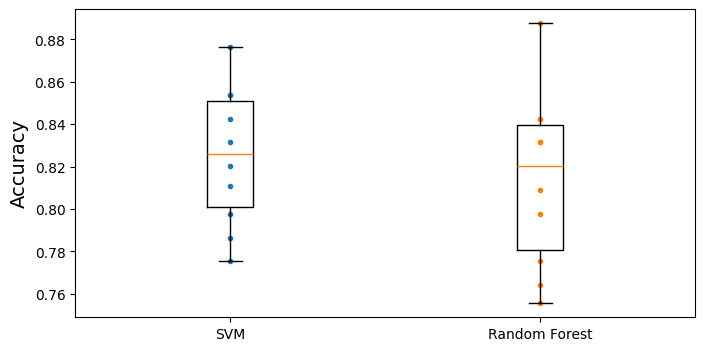

In [93]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, rf_scores, ".")
plt.boxplot([svm_scores, rf_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

In [94]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [95]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(
    ['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [106]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15.0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,15.0,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30.0,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30.0,0


In [107]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

#Numerical Preprocessing pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

#Categorical Preprocessing pipeline
cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(sparse_output=False))
])

num_attribs = ["Age", "Fare", "RelativesOnboard"]
cat_attribs = ["Pclass", "Sex", "Embarked", "AgeBucket"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

X_train = preprocess_pipeline.fit_transform(train_data)
X_train


array([[-0.56573582, -0.50244517,  0.05915988, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.6638609 ,  0.78684529,  0.05915988, ...,  0.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.48885426, -0.56097483, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.10463705, -0.17626324,  1.29942929, ...,  0.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.04438104, -0.56097483, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.49237783, -0.56097483, ...,  0.        ,
         0.        ,  0.        ]])

In [111]:
from sklearn.model_selection import GridSearchCV

params = [{"n_estimators": [i for i in range(1,100)]}]

grid_search = GridSearchCV(rf_clf, params, cv = 10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19, 20,
                                           21, 22, 23, 24, 25, 26, 27, 28, 29,
                                           30, ...]}])

In [112]:
grid_search.best_params_

{'n_estimators': 96}

In [114]:
#grid_search.best_estimator_.fit(X_train, y_train)

cross_val_score(grid_search.best_estimator_, X_train, y_train, cv= 10).mean()

np.float64(0.8137578027465668)

In [117]:
params = [{"gamma":["scale", "auto"], "degree":[2,3,4,5]}]
grid_search = GridSearchCV(svm_clf, params, cv = 10)
grid_search.fit(X_train, y_train)
cross_val_score(grid_search.best_estimator_, X_train, y_train, cv = 10).mean()

np.float64(0.8305368289637952)

In [119]:
grid_search.best_params_

{'degree': 2, 'gamma': 'scale'}